In [4]:
import numpy as np
import pickle
import zipfile
import tempfile
from typing import List, Optional, Tuple
from pathlib import Path
from cgmml.common.depthmap_toolkit.constants import EXTRACTED_DEPTH_FILE_NAME
from cgmml.common.depthmap_toolkit.depthmap import Depthmap
from PIL import Image
from cgmml.common.background_segmentation.deeplab.deeplab_model import get_deeplab_model, PERSON_SEGMENTATION

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import sys
sys.path.append('../../cgm-ml-copy')

In [5]:
DEEPLAB_MODEL = get_deeplab_model()

2023-06-06 13:26:22.205358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-06 13:26:22.550064: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-06 13:26:22.550136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pksingh1): /proc/driver/nvidia/version does not exist
2023-06-06 13:26:22.551780: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-06-06 13:26:22.561585: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2593905000 Hz
2023-06-06 13:26:22.561878: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab48000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06

In [6]:
def extract_depthmap(depthmap_fpath: str, dest_dir: str) -> Path:
    """Extract depthmap from given file"""
    with zipfile.ZipFile(Path(depthmap_fpath), 'r') as zip_ref:
        zip_ref.extractall(dest_dir)
    return Path(dest_dir) / EXTRACTED_DEPTH_FILE_NAME


In [7]:
def read_depthmap_data(depthmap_fpath):
    with tempfile.TemporaryDirectory() as tmpdirname:
        path = extract_depthmap(depthmap_fpath, tmpdirname)
        with open(path, 'rb') as f:
            header_line = f.readline().decode().strip()
            width, height, depth_scale, max_confidence, device_pose = Depthmap.parse_header(header_line)
            data = f.read()
            f.close()
    return width, height, data, depth_scale, max_confidence, device_pose, header_line

## segmentation map extraction for sample image

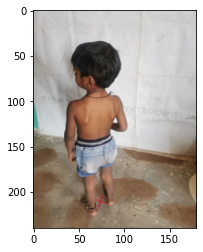

In [272]:
from matplotlib import pyplot as plt
rgb_file = '../feature_analysis/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/rgb/4.jpg'
im = Image.open(rgb_file).rotate(-90, expand=True)
im.save('rotated_image.jpg')

plt.imshow(im)

resized_im, seg_map = DEEPLAB_MODEL.run(im)
plt.imshow(seg_map)

resized_im = resized_im.resize(new_size)
plt.imshow(resized_im)

# seg_map[seg_map != PERSON_SEGMENTATION] = 0

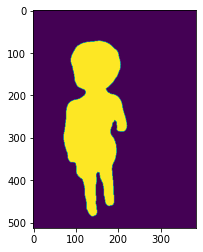

In [273]:
plt.imshow(seg_map)


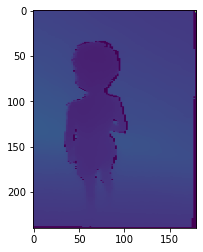

In [173]:
depthmap_file = '../feature_analysis/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/depth/4.zip'
calibration_file = '../feature_analysis/scans/cef7be21-b99d-11ed-a07e-1f06179fe4a4/calibration/0'
dmap = Depthmap.create_from_zip_absolute(depthmap_file, 0, calibration_file)
# dmap.resize(seg_map.shape[0], seg_map.shape[1])
depthmap = dmap.depthmap_arr
plt.imshow(depthmap)

## Overlaying the segmentation map and depthmap

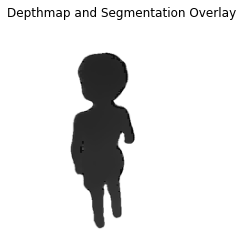

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the depthmap and segmentation map as numpy arrays
# depthmap = ...  # Depthmap array of shape (height, width)
# segmentation = ...  # Segmentation map array of shape (height, width)

# Normalize the depthmap and segmentation values
depthmap_normalized = depthmap / np.max(depthmap)
segmentation_normalized = segmentation / np.max(segmentation)

# Create a blank RGBA image
rgba_image = np.zeros((depthmap.shape[0], depthmap.shape[1], 4), dtype=np.float32)

# Set the RGB channels of the RGBA image to the depthmap values
rgba_image[..., :3] = np.expand_dims(depthmap_normalized, axis=2)

# Set the alpha channel of the RGBA image to the segmentation values
rgba_image[..., 3] = segmentation_normalized

# Display the overlaid image
plt.imshow(rgba_image)
plt.axis('off')
plt.title('Depthmap and Segmentation Overlay')
plt.show()


## Code to create dataset in pickle format

In [ ]:
import os
import glob
from PIL import Image
import cv2
import numpy as np
import pickle
import random

# Define the folder paths
scan_folder = 'scans/'

NEW_SIZE = (180, 240)


# Get the list of subfolders in the scan folder
subfolders = glob.glob(os.path.join(scan_folder, '*'))

# Iterate over the subfolders
for subfolder in subfolders:
    # Get the scan_id from the subfolder path
    scan_id = os.path.basename(subfolder)
    
    # Get the list of depthmap files in the current subfolder
    depthmap_files = glob.glob(os.path.join(subfolder, 'depth', '*.zip'))
    
    # Get the list of segmentation map files in the current subfolder
#     segmap_files = glob.glob(os.path.join(subfolder, 'segmap', '*.png'))
    
    rgb_files = glob.glob(os.path.join(subfolder, 'rgb', '*.jpg'))
    # Create the pickle folder if it doesn't exist
    pickle_folder = os.path.join(subfolder, 'pickle')
    os.makedirs(pickle_folder, exist_ok=True)
    
    # Iterate over the depthmap and segmentation map files
    for depthmap_file, rgb_file in zip(depthmap_files, rgb_files):
        # Load and process the depthmap
        dmap = Depthmap.create_from_zip_absolute(depthmap_file, 0, calibration_file)
        depthmap = dmap.depthmap_arr
        
        # Load rgb image and create segmentation map
        im = Image.open(rgb_file).rotate(-90, expand=True)
        resized_im, seg_map = DEEPLAB_MODEL.run(im)
        numpy_array = seg_map.astype(np.uint8)
        segmap = Image.fromarray(numpy_array)
        segmap = segmap.resize(NEW_SIZE)
        
        resized_im = resized_im.resize(NEW_SIZE)
        segmap_shape = (segmap.size[1],segmap.size[0])
        # Check if the dimensions of segm_arr and depthmap are the same
        if segmap_shape != depthmap.shape:
            # Print error message and skip processing the file
            print(f"Error: Segmentation map and depthmap dimensions do not match for file '{segmap_file}'. Skipping file.")
            continue
        
        # Expand the dimensions of the depthmap array to match the shape of the segmentation array
        expanded_depthmap_arr = np.expand_dims(depthmap, axis=2)
        segm_arr = np.expand_dims(segmap, axis=2)
        resized_im = np.array(resized_im)
        # Concatenate the depthmap and segmentation map arrays
        
#         concatenated_arr = np.concatenate((expanded_depthmap_arr,resized_im ,segm_arr), axis=2)
        
        # Create the dictionary with 'height' key and a random number between 90 and 100
        data_dict = {'height': random.uniform(90, 100)}
        
        # Get the file name of the depthmap zip file
        depthmap_filename = os.path.basename(depthmap_file)
        
        # Define the output pickle file path
        output_file = os.path.join(pickle_folder, depthmap_filename.replace('.zip', '.p'))
        
        # Save the concatenated array and the dictionary in the pickle file
        with open(output_file, 'wb') as f:
            pickle.dump([expanded_depthmap_arr,resized_im ,segm_arr, data_dict], f)


## Visualising the output pickle

Height: 96.58208748912823


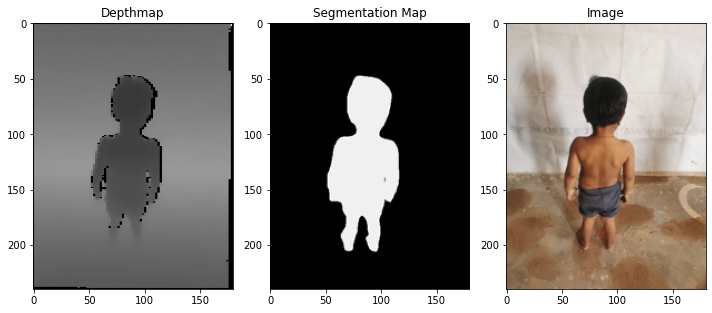

In [270]:
pickle_file = 'scans/d1093900-b99d-11ed-a07e-c784d64acc4f/pickle/2.p'

# Load the pickle file
with open(pickle_file, 'rb') as f:
    data = pickle.load(f)

# Access the concatenated array, depthmap, and segmentation
depthmap = data[0]
segm_arr = data[2]
image = data[1]

# Access the height value
height = data[3]['height']

# Visualize the depthmap and segmentation
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(depthmap, cmap='gray')
axs[0].set_title('Depthmap')
axs[1].imshow(segm_arr, cmap='gray')
axs[1].set_title('Segmentation Map')
axs[2].imshow(image)
axs[2].set_title('Image')

# Display the height value
print(f"Height: {height}")

# Show the plots
plt.tight_layout()
plt.show()


## overlay of segmentation on top of depthmap 

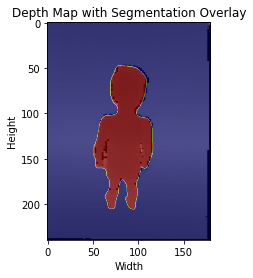

In [228]:
import matplotlib.pyplot as plt

# Assuming you have the image stored in the 'image' variable

# Split the image into the depth map and segmentation map
depth_map = concatenated_arr[:, :, 0]
segmentation_map = concatenated_arr[:, :, 1]

# Create a figure and axes
fig, ax = plt.subplots()

# Display the depth map
ax.imshow(depth_map, cmap='gray')

# Overlay the segmentation map with alpha blending
ax.imshow(segmentation_map, cmap='jet', alpha=0.5)

# Set the title and labels
ax.set_title('Depth Map with Segmentation Overlay')
ax.set_xlabel('Width')
ax.set_ylabel('Height')

# Show the plot
plt.show()
